In [0]:
# Setup stocklab
!git clone https://github.com/hchsiao/stocklab.git
!cd stocklab; pip install -e .
!git clone https://github.com/hchsiao/stocklab-twse.git
!cd stocklab-twse; pip install -e .

import sys
import os
sys.path.append(f'{os.getcwd()}/stocklab') # so that we don't have to restart kernel

In [0]:
# Configurate stocklab
cfg = """---
config_name: stocklab-twse
force_offline: false
timezone_offset: 8
root_dir: ./stocklab-twse/
#today_is: 2020-04-30
stocks_of_interest: active_stock_list
database:
  type: sqlite
  filename: db.sqlite
  rebuild-metadata: false
cache:
  type: sqlite
  filename: cache.sqlite
  rebuild-metadata: false
"""
assert len(cfg) == open('config.yaml', 'w').write(cfg)

In [3]:
import logging
import stocklab
from stocklab.lang import expr as e
from stocklab.lang import meta as m
stocklab.change_log_level(logging.INFO)

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
[INFO] stock_list: Start default meta-module refresh routine
[INFO] stock_list: Refresh required, preparing...
[INFO] stock_list: Refresh ends
[INFO] trade_dates: Refresh required, preparing...
[INFO] last_trade_date: Start default meta-module refresh routine
[INFO] last_trade_date: Refresh required, preparing...
[INFO] last_trade_date: Refresh ends
[INFO] trade_dates: Update complete
[INFO] suspended_stock_list: Start default meta-module refresh routine
[INFO] suspended_stock_list: Refresh required, preparing...
[INFO] suspended_stock_list: Refresh ends
[INFO] etf_stock_list: Start default meta-module refresh routine
[INFO] etf_stock_list: Refresh required, preparing

## Data access interface
- ```stocklab.evaluate()```: for modules with data passively crawled (will not be loaded until they are required)
- ```stocklab.metaevaluate()```: for modules with data actively crawled (stocklab will update its database before any evaluation)


In [4]:
# stocklab.evaluate: a mapping from string (expression) to data
expression = 'ohlc.2330.20200430'
o, h, l, c = stocklab.evaluate(expression)
print(f'Quote of TSMC(2330) @ 2020-04-30: open={o}, high={h}, low={l}, close={c}')

# alternatively, stocklab.lang can also be used to build and evaluate an expression
assert e.ohlc._2330._20200430 == (o, h, l, c)

# expressions 'trade_dates.*' evaluates to a series of trade dates (w/o weekend & holidays)
print('7 trade days BEFORE 2020-03-30:',
      stocklab.metaevaluate('trade_dates.20200330.7.lag'))
print('7 trade days AFTER 2020-03-30:',
      stocklab.metaevaluate('trade_dates.20200330.7.lead'))

# list args expension
print('Quotes of TSMC for 3 consecutive trade days until 2020-04-30:',
      stocklab.evaluate('ohlc.2330.($trade_dates.20200430.3.lag)'))

[INFO] twse: Data(2330.2020-04-30) does not exist in DB, crawling...


Quote of TSMC(2330) @ 2020-04-30: open=302.0, high=305.0, low=301.5, close=304.5
7 trade days BEFORE 2020-03-30: [2020-03-20, 2020-03-23, 2020-03-24, 2020-03-25, 2020-03-26, 2020-03-27, 2020-03-30]
7 trade days AFTER 2020-03-30: [2020-03-30, 2020-03-31, 2020-04-01, 2020-04-06, 2020-04-07, 2020-04-08, 2020-04-09]
Quotes of TSMC for 3 consecutive trade days until 2020-04-30: [(298.5, 298.5, 294.5, 296.5), (299.0, 301.5, 298.0, 299.0), (302.0, 305.0, 301.5, 304.5)]


[INFO] twse: Data(2330.2020-02-04) does not exist in DB, crawling...
[INFO] twse: Data(2330.2020-03-02) does not exist in DB, crawling...
[INFO] twse: Data(2330.2020-01-15) does not exist in DB, crawling...


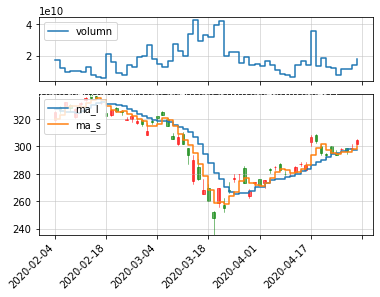

In [5]:
# plots are, of course, indespensable
import numpy as np
from stocklab.utils import plot

date = 20200430
days = 60
stock_id = 2330

dates_expr = f'trade_dates.{date}.{days}.lag'
dates = stocklab.metaevaluate(dates_expr)
ohlcs = np.asarray(stocklab.evaluate(f'ohlc.{stock_id}.(${dates_expr})'))

ma_l = np.asarray(stocklab.evaluate(f'moving_average.{stock_id}.(${dates_expr}).8'))
ma_s = np.asarray(stocklab.evaluate(f'moving_average.{stock_id}.(${dates_expr}).3'))

plot(dates, ohlcs,
    aux={
      'ma_l': ma_l,
      'ma_s': ma_s
      },
    top_aux={
      'volumn': stocklab.evaluate(f'volumn.{stock_id}.(${dates_expr})')
      }
    )

Here we implement a module 'my_sign' to represent the buy-sell signal.

---

Modules can be found by stocklab if it is
1. written in *.py placed in 'modules/' directory, or
2. following ```@stocklab.declare``` directive



In [6]:
import numpy as np
from stocklab.datetime import Date
from stocklab.utils import simulate, plot, random_simulate

@stocklab.declare
class my_sign(stocklab.Module):
  spec = {
      'args': [
        'stock_id', # field name: 'stock_id' with type: str
        ('date', Date), # field name: 'date' with type: stocklab.datetime.Date
        ]
      }
  def evaluate(self, db, args):
    dates_expr = f'trade_dates.{args.date}.2.lag'
    ma_l = stocklab.evaluate(f'moving_average.{args.stock_id}.(${dates_expr}).8')
    ma_s = stocklab.evaluate(f'moving_average.{args.stock_id}.(${dates_expr}).3')
    ml = ma_l[1] - ma_l[0]
    ms = ma_s[1] - ma_s[0]
    cross = (ma_l[1] - ma_s[1]) * (ma_l[0] - ma_s[0]) <= 0
    bear = ml > ms # sell when slow MA exceed fast MA
    bull = ml < ms # buy when fast MA exceed slow MA
    return (0 if not cross else 1 if bull else -1 if bear else 0)

# Example evaluation (1 means BUY, -1 means SELL)
expr = 'my_sign.2330.($trade_dates.20200430.10.lag)'
print(f'{expr} evaluates to :', stocklab.evaluate(expr))

my_sign.2330.($trade_dates.20200430.10.lag) evaluates to : [0, 0, 0, 0, 0, -1, 0, 0, 1, 0]


In [7]:
# With a strategy 'my_sign' at hand, one may evaluate its performance
date = 20200424
days = 50

# pick a stock randomly and simulate
print(f'Start backtesting for {days} days (end in {date})')
rand_sim = random_simulate(date, days, verbose=True,
    dates_expr=lambda d, n: f'trade_dates.{d}.{n}.lag',
    ohlc_expr=lambda s, d: f'ohlc.{s}.{d}',
    sign_expr=lambda s, d: f'my_sign.{s}.{d}'
    )
stock_id, gain = next(rand_sim)
print(f'stock_id: {stock_id}, capital gain: {gain:.3}')

[INFO] twse: Data(2337.2020-02-12) does not exist in DB, crawling...


Start backtesting for 50 days (end in 20200424)


[INFO] twse: Data(2337.2020-03-02) does not exist in DB, crawling...
[INFO] twse: Data(2337.2020-04-01) does not exist in DB, crawling...
[INFO] twse: Data(2337.2020-01-31) does not exist in DB, crawling...


[2020-03-06] buy @ 34.95
[2020-03-12] sell @ 30.65 (gain: -4.3)
[2020-03-26] buy @ 26.45
[2020-04-24] sell (terminate) @ 34.15 (gain: 7.7)
stock_id: 2337, capital gain: 3.4


On the candle plot: red bar means sell, green bar means buy


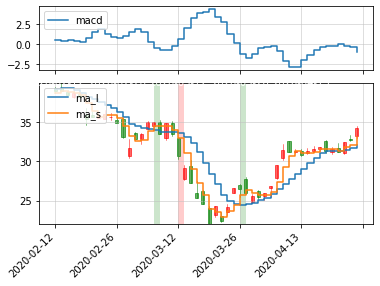

In [8]:
# One may also visualize the strategy (my_sign in this case)
dates_expr = f'trade_dates.{date}.{days}.lag'
dates = stocklab.metaevaluate(dates_expr)
ohlcs = np.asarray(stocklab.evaluate(f'ohlc.{stock_id}.(${dates_expr})'))
prices = ohlcs[:,3]
signs = stocklab.evaluate(f'my_sign.{stock_id}.(${dates_expr})')

ma_l = np.asarray(stocklab.evaluate(f'moving_average.{stock_id}.(${dates_expr}).8'))
ma_s = np.asarray(stocklab.evaluate(f'moving_average.{stock_id}.(${dates_expr}).3'))

print('On the candle plot: red bar means sell, green bar means buy')
plot(dates, ohlcs, signs,
    aux={
      'ma_l': ma_l,
      'ma_s': ma_s
      },
    top_aux={
      'macd': ma_l - ma_s
      }
    )